In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [53]:
df_in_ = np.random.normal(2, 1, 1000)
df_out_ = np.random.normal(0, 2, 1000)

In [54]:
df_in = (df_in_ - np.mean(df_in_)) / np.std(df_in_)
df_out = (df_out_ - np.mean(df_out_)) / np.std(df_out_)


<AxesSubplot:>

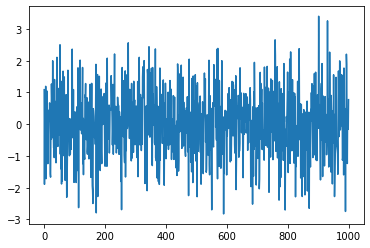

In [55]:
sns.lineplot(data = df_in)

In [56]:


train_size = int(len(df_in) * 0.8)
test_size = len(df_in) - train_size

train_input, test_input = df_in[0:train_size], df_in[train_size:len(df_in)]
train_output, test_output = df_in[0:train_size], df_out[train_size:len(df_in)]



In [57]:
n_timesteps_in = 50 
n_timesteps_out = 50

n_features_in = 1
n_features_out = 1

In [58]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = np.random.randint(0, len(train_input) - seq_len)
        input_seq = df_in[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = df_out[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = np.random.randint(0, len(test_input) - seq_len)
        input_seq = df_in[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = df_out[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

In [59]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

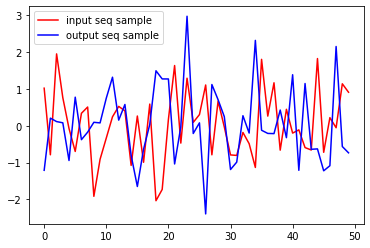

In [60]:


plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()



In [61]:
from keras.layers import LSTM, Input, Dense, GRU
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping

In [62]:

train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))



In [63]:


n_units = 256

encoder_inputs = Input(shape=(n_timesteps_in, n_features_in))
encoder = LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

decoder_inputs = Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_dense = Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [64]:
model_lstm.compile(optimizer='adam', loss='mse')

In [65]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [EarlyStopping(patience=5)]

model_lstm.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 7s - loss: 0.9820 - val_loss: 1.0087 - 7s/epoch - 1s/step
Epoch 2/100
7/7 - 2s - loss: 0.9807 - val_loss: 1.0082 - 2s/epoch - 235ms/step
Epoch 3/100
7/7 - 2s - loss: 0.9802 - val_loss: 1.0076 - 2s/epoch - 248ms/step
Epoch 4/100
7/7 - 2s - loss: 0.9801 - val_loss: 1.0079 - 2s/epoch - 238ms/step
Epoch 5/100
7/7 - 2s - loss: 0.9799 - val_loss: 1.0072 - 2s/epoch - 268ms/step
Epoch 6/100
7/7 - 2s - loss: 0.9790 - val_loss: 1.0076 - 2s/epoch - 300ms/step
Epoch 7/100
7/7 - 2s - loss: 0.9789 - val_loss: 1.0078 - 2s/epoch - 304ms/step
Epoch 8/100
7/7 - 2s - loss: 0.9780 - val_loss: 1.0066 - 2s/epoch - 293ms/step
Epoch 9/100
7/7 - 2s - loss: 0.9781 - val_loss: 1.0063 - 2s/epoch - 292ms/step
Epoch 10/100
7/7 - 2s - loss: 0.9766 - val_loss: 1.0047 - 2s/epoch - 320ms/step
Epoch 11/100
7/7 - 2s - loss: 0.9764 - val_loss: 1.0044 - 2s/epoch - 272ms/step
Epoch 12/100
7/7 - 2s - loss: 0.9750 - val_loss: 1.0048 - 2s/epoch - 258ms/step
Epoch 13/100
7/7 - 2s - loss: 0.9742 - val_loss: 1.0

In [66]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model_lstm.predict([test_input_data, decoder_inputs])

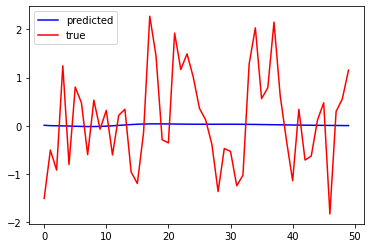

In [67]:

plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()



In [68]:
encoder_inputs = Input(shape=(n_timesteps_in, n_features_in))
encoder = GRU(n_units, return_sequences=False, return_state=True)
_, state = encoder(encoder_inputs)

decoder_inputs = Input(shape=(n_timesteps_out, n_features_out))
decoder_gru =  GRU(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, = decoder_gru(decoder_inputs, initial_state=[state])
decoder_dense = Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [69]:
model.compile(optimizer='adam', loss='mse')

In [70]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 5s - loss: 0.9824 - val_loss: 1.0093 - 5s/epoch - 707ms/step
Epoch 2/100
7/7 - 1s - loss: 0.9817 - val_loss: 1.0094 - 1s/epoch - 187ms/step
Epoch 3/100
7/7 - 2s - loss: 0.9818 - val_loss: 1.0094 - 2s/epoch - 238ms/step
Epoch 4/100
7/7 - 2s - loss: 0.9816 - val_loss: 1.0092 - 2s/epoch - 226ms/step
Epoch 5/100
7/7 - 1s - loss: 0.9817 - val_loss: 1.0092 - 1s/epoch - 183ms/step
Epoch 6/100
7/7 - 1s - loss: 0.9816 - val_loss: 1.0091 - 1s/epoch - 189ms/step
Epoch 7/100
7/7 - 2s - loss: 0.9816 - val_loss: 1.0090 - 2s/epoch - 259ms/step
Epoch 8/100
7/7 - 2s - loss: 0.9816 - val_loss: 1.0093 - 2s/epoch - 245ms/step
Epoch 9/100
7/7 - 1s - loss: 0.9816 - val_loss: 1.0090 - 1s/epoch - 198ms/step
Epoch 10/100
7/7 - 1s - loss: 0.9816 - val_loss: 1.0090 - 1s/epoch - 214ms/step
Epoch 11/100
7/7 - 1s - loss: 0.9813 - val_loss: 1.0094 - 1s/epoch - 203ms/step
Epoch 12/100
7/7 - 2s - loss: 0.9813 - val_loss: 1.0089 - 2s/epoch - 233ms/step
Epoch 13/100
7/7 - 1s - loss: 0.9812 - val_loss: 

In [71]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

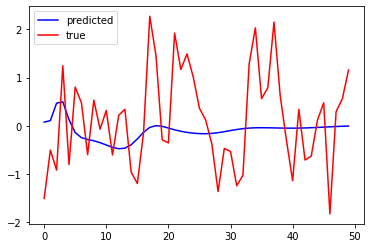

In [72]:

plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

